### 1. Preprocesesing

In [1]:
df_train = pd.read_excel('./data/job_train.xlsx')

In [2]:
# X : job description's 'responsibilities' and 'requirements' on LinkedIn
# y : {0 : 'Data Science', 1 : 'Digital Marketer', 2 : 'UX/UI Designer'}
df_train.tail(3)

,X,y,y_name
298,98.. HTML/ CSS/ Javascipt Angular.js Photoshop...,2,UX/UI Designer
299,99.. 5-8 years of Software/Application Enginee...,2,UX/UI Designer
300,"100.. Develop high level and detailed mockups,...",2,UX/UI Designer


In [3]:
X_train = df_train['X'].values
y_train = df_train['y'].values

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(analyzer='word', stop_words='english', min_df=50)
X_train_count_vect = count_vect.fit_transform(X_train)

tfidf_transform = TfidfTransformer()
X_train_tfidf_transform = tfidf_transform.fit_transform(X_train_count_vect)

In [5]:
# make columns with vocabularies (bag of words) appeared in samples
column = [count_vect.vocabulary_.keys()]
X_train_count = count_vect.transform(X_train).toarray()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count_vect).toarray()

In [6]:
# frequency count
pd.DataFrame(data=X_train_count, columns=column).head(3)

,skills,new,machine,content,project,best,modeling,practices,creative,support,...,software,including,related,management,data,quantitative,able,based,written,ability
0,2,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,2,0,2,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,2,1,2,3,2,2,0,1,1,9,...,1,0,1,0,0,0,3,0,1,0


In [7]:
# tfidf count
pd.DataFrame(data=X_train_tfidf, columns=column).head(3)

,skills,new,machine,content,project,best,modeling,practices,creative,support,...,software,including,related,management,data,quantitative,able,based,written,ability
0,0.138983,0.000000,0.000000,0.000000,0.095460,0.000000,0,0.000000,0.000000,0.089198,...,0.000000,0,0.000000,0,0,0,0.000000,0,0.000000,0.000000
1,0.078083,0.000000,0.219677,0.000000,0.214526,0.142639,0,0.000000,0.000000,0.100226,...,0.000000,0,0.000000,0,0,0,0.000000,0,0.000000,0.069415
2,0.068019,0.056752,0.095681,0.161612,0.093438,0.124254,0,0.062565,0.061276,0.392885,...,0.044039,0,0.049511,0,0,0,0.109529,0,0.050267,0.000000


----

### 2. Model, Feature Selection

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from matplotlib.pyplot import axvline, axhline
from sklearn.metrics import precision_score, accuracy_score, recall_score

#### parameter tuning

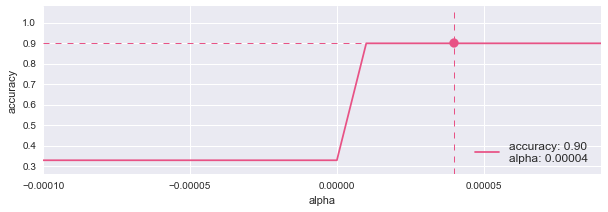

In [9]:
# go through cross validation 
# search optimal parameter that maximizes classification performance

cv = StratifiedKFold(y_train, n_folds=10, random_state=0)
score_range = []
parameter_range = []

for parameter in np.arange(-1e-4, 1e-4, 1e-5):
    clf_MNB = MultinomialNB(alpha=parameter)
    scores = np.zeros(10)

    for i, (train_idx, validation_idx) in enumerate(cv):
        X_train_ = X_train_tfidf[train_idx]
        y_train_ = y_train[train_idx]
        X_validation = X_train_tfidf[validation_idx]
        y_validation = y_train[validation_idx]
        
        clf_MNB.fit(X_train_, y_train_)
        y_predicted = clf_MNB.predict(X_validation)
        scores = round(accuracy_score(y_predicted, y_validation), 2)
        
    score_range.append(scores)
    parameter_range.append(parameter)
    dictionary = dict(zip(parameter_range, score_range))


plt.figure(figsize = (10, 3))
plt.plot(parameter_range, score_range, color='#E85285', label='accuracy: %(n)0.2f \nalpha: %(v)0.5f' % 
         {'n': max(dictionary.values()), 
          'v': max(dictionary.items(), key=lambda x: x[1])[0] })
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.legend(loc='lower right', prop={'size':12})
plt.scatter([max(dictionary.items(), key=lambda x: x[1])[0], ], [max(dictionary.values()), ], 80, color='#E85285')
axhline(max(dictionary.values()), color='#E85285', linewidth=1, linestyle='--')
axvline(max(dictionary.items(), key=lambda x: x[1])[0], color='#E85285', linewidth=1, linestyle='--')
plt.xlim(min(parameter_range), max(parameter_range))
plt.ylim(min(score_range)*0.8, max(score_range)*1.2);

#### classification performance evaluation

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier 
# baseline confirmation, implying that model has to perform at least as good as it
# since all 3 classes respectively have 100 samples, baseline performance is 0.33
clf_dummy = DummyClassifier(strategy='most_frequent')
clf_dummy = clf_dummy.fit(X_train_, y_train_)
print('baseline score =>', round(clf_dummy.score(X_validation, y_validation), 2))

baseline score => 0.33


In [11]:
# fit train data to the classifier with alpha being 0.00004
clf_MNB = MultinomialNB(alpha=0.00004)
clf_MNB.fit(X_train_, y_train_)
y_predicted = clf_MNB.predict(X_validation)

In [12]:
# print classification report to see the performancce of classifier
# we can see that the model has well classified class 0, data scientist.
# precision(0.91), recall(0.90), f1-score(0.90), accuracy(0.9) all far outperform the baseline (0.33).
# Though four types of scores are very similar to each other, I will focus on 'accuracy' on this project
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['(0) Data Scientist', '(1) Digital Marketer', '(2) UX/UI Designer']
print(classification_report(y_validation, y_predicted, target_names=target_names))

                      precision    recall  f1-score   support

  (0) Data Scientist       0.91      1.00      0.95        10
(1) Digital Marketer       0.82      0.90      0.86        10
  (2) UX/UI Designer       1.00      0.80      0.89        10

         avg / total       0.91      0.90      0.90        30



[[10  0  0]
 [ 1  9  0]
 [ 0  2  8]]


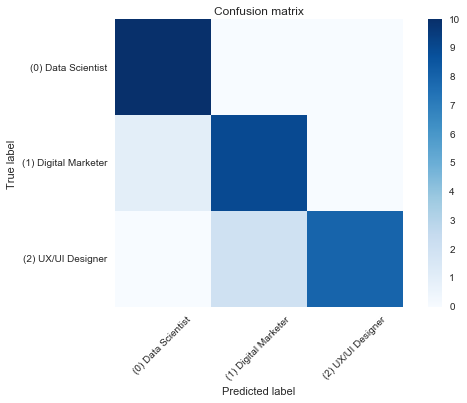

In [13]:
# this is pretty much the same as above
cm = confusion_matrix(y_validation, y_predicted)
print(cm)
plt.grid(False)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### building a model with pipeline, gridsearch

In [14]:
# use pipeline to tune parameters of countvectorizer, tfidftransformer, and multinomial Naive Bayes simultaneously
# parameter tuning itself can be done by aid of GridSearhCV below
from sklearn.pipeline import Pipeline
pipeline_clf_train = Pipeline(
    steps=[
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf_MNB', MultinomialNB()),
    ]
);

In [15]:
# the intention of including bigram is to extract noun phrasse, if necessary
# tfidf__use_idf: False was quite suprising.

from sklearn.grid_search import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf' : [True, False],
    'clf_MNB__alpha' : np.arange(0, 0.00005, 0.000005),
}
gs_clf = GridSearchCV(pipeline_clf_train, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

In [16]:
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
print('------------------------------')
print('score :', score.round(2))

clf_MNB__alpha: 1.5000000000000002e-05
tfidf__use_idf: False
vect__ngram_range: (1, 1)
------------------------------
score : 0.97


### 3. Test

In [17]:
# test data to test model's performance
df_test = pd.read_excel('./data/job_test.xlsx')
X_test = df_test['X'].values
y_test = df_test['y'].values
df_test.tail(3)

,X,y,y_name
148,"Benefits package including medical, dental, vi...",2,UX/UI Designer
149,"Extensive experience designing beautiful, enga...",2,UX/UI Designer
150,"Tackle complex problems and provide elegant, c...",2,UX/UI Designer


In [18]:
pipeline_clf_test = Pipeline(
    steps=[
        ('vect', CountVectorizer(ngram_range=(1, 1), stop_words='english', min_df=25)),
        ('clf', MultinomialNB(alpha=1.5000000000000002e-05))
    ]
)
pipeline_clf_test = pipeline_clf_test.fit(X_train, y_train)
y_predicted = pipeline_clf_test.predict(X_test)

print("Prediction Accuracy =>" , np.mean(y_test == y_predicted).round(2))

Prediction Accuracy => 0.99


-----

### 4. Prediction (raw input)

In [23]:
docs = [raw_input()]
categories = ['Data Scientist', 'Digital Marketer', 'UX/UI Designer']

predicted = pipeline_clf_test.predict(docs)[0]
prob = pipeline_clf_test.predict_proba(list(docs))[0]
prob_gap = np.max(prob) - np.median(prob)

if prob_gap > 0.4:
    print("\n==== Your job ====")
    print(categories[predicted])
    print("\n=== Probability ===")
    print(prob[predicted].round(2))
    
else:
    print("+++More detailed words please+++")    

analytic logical critical thinking passion prudent communication not very creative problem solving positive want-to-be tech savvy data-driven result-oriented speedy 

==== Your job ====
Data Scientist

=== Probability ===
0.86


----

### 5. Visualization

C:\Anaconda2\lib\site-packages\PIL\ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


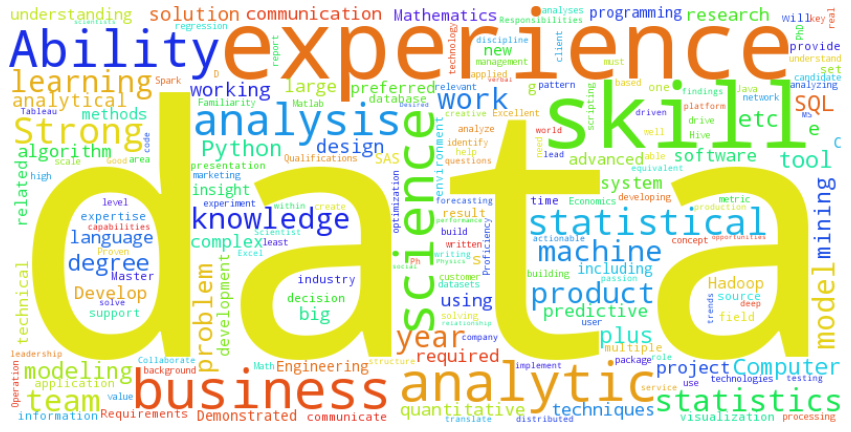

In [20]:
# data scientist
from wordcloud import WordCloud
word_ds = " ".join(df_train[df_train['y'] == 0]['X'])
wordcloud_ds = WordCloud(background_color='white', width=800, height=400).generate(word_ds)
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud_ds.recolor(random_state=4))
plt.xticks([])
plt.yticks([])
plt.grid(False);

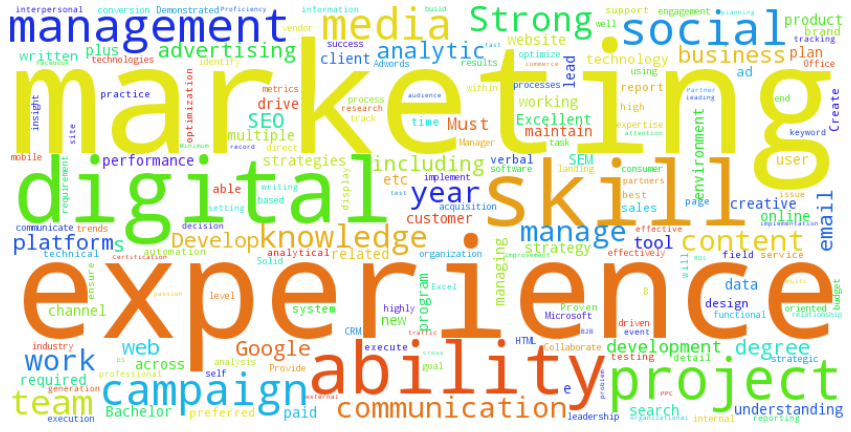

In [21]:
# digital marketer
word_dm = " ".join(df_train[df_train['y'] == 1]['X'])
wordcloud_dm = WordCloud(background_color='white', width=800, height=400).generate(word_dm)
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud_dm.recolor(random_state=4))
plt.xticks([])
plt.yticks([])
plt.grid(False);

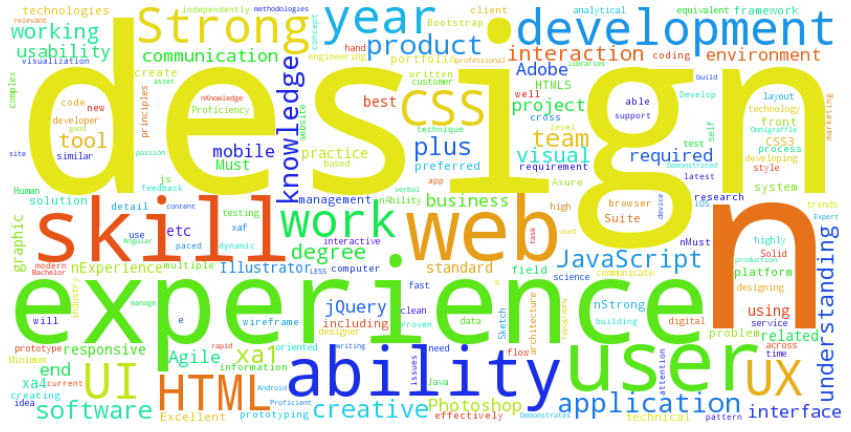

In [22]:
# UX/UI designer
word_design = " ".join(df_train[df_train['y'] == 2]['X'])
wordcloud_design = WordCloud(background_color='white', width=800, height=400).generate(word_design)
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud_design.recolor(random_state=4))
plt.xticks([])
plt.yticks([])
plt.grid(False);